<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP
# Notebook 2 - Data Cleaning, Preprocessing & EDA

2.1 [Data Cleaning](#2.1-Data-Cleaning)<br>
2.2 [Preprocessing](#2.2-Preprocessing)<br>
2.3 [EDA](#2.3-EDA)<br>
2.4 [Data Cleaning for Modeling](#2.4-Data-Cleaning-for-Modeling)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import demoji

from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# import datasets
coffee = pd.read_csv('../datasets/coffee_scraped.csv')
tea = pd.read_csv('../datasets/tea_scraped.csv')

In [3]:
# set display options
pd.set_option('display.max_colwidth', None)

## 2.1 Data Cleaning
- Drop rows with posts that were removed on reddit by moderators
- Drop repetitive posts by moderators
- Drop duplicated posts
- Extract only columns that will be used in analysis ('created_utc', 'subreddit', 'title',  'selftext')
- Create new column that represents the concatenation of title and body text

In [4]:
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14979 entries, 0 to 14978
Data columns (total 82 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  14979 non-null  object 
 1   allow_live_comments            14979 non-null  bool   
 2   author                         14979 non-null  object 
 3   author_flair_css_class         0 non-null      float64
 4   author_flair_richtext          14949 non-null  object 
 5   author_flair_text              841 non-null    object 
 6   author_flair_type              14949 non-null  object 
 7   author_fullname                14949 non-null  object 
 8   author_is_blocked              14979 non-null  bool   
 9   author_patreon_flair           14949 non-null  object 
 10  author_premium                 14949 non-null  object 
 11  awarders                       14979 non-null  object 
 12  can_mod_post                   14979 non-null 

In [5]:
coffee[coffee['removed_by_category'].notnull()].shape # check if there're any posts that are already removed on reddit 

(1100, 82)

In [6]:
coffee = coffee[coffee['removed_by_category'].isnull()] # drop rows with posts that have already been removed on reddit

In [7]:
coffee_extract = coffee[['created_utc', 'subreddit', 'title',  'selftext']] # extract columns to be used for analysis

In [8]:
coffee_extract.shape

(13879, 4)

In [9]:
coffee_extract.drop_duplicates(subset = ['title', 'selftext'], inplace = True) # remove duplicate posts
coffee_extract = coffee_extract.reset_index(drop = True)

In [10]:
coffee_extract.shape

(13370, 4)

In [11]:
coffee_extract['selftext'].fillna('', inplace = True) 

In [12]:
coffee_extract['post'] = coffee_extract['title'] + " " + coffee_extract['selftext'] # new column that represents title + selftext

In [13]:
tea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14971 entries, 0 to 14970
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  14971 non-null  object 
 1   allow_live_comments            14971 non-null  bool   
 2   author                         14971 non-null  object 
 3   author_flair_css_class         0 non-null      float64
 4   author_flair_richtext          14930 non-null  object 
 5   author_flair_text              307 non-null    object 
 6   author_flair_type              14930 non-null  object 
 7   author_fullname                14930 non-null  object 
 8   author_is_blocked              14971 non-null  bool   
 9   author_patreon_flair           14930 non-null  object 
 10  author_premium                 14930 non-null  object 
 11  awarders                       14971 non-null  object 
 12  can_mod_post                   14971 non-null 

In [14]:
tea[tea['removed_by_category'].notnull()].shape # check if there're any posts that are already removed on reddit 

(2570, 85)

In [15]:
tea = tea[tea['removed_by_category'].isnull()] # drop rows with posts that have already been removed on reddit

In [16]:
tea.groupby('author')['title'].count().sort_values(ascending = False).head() # identify author with highest number of submissions

author
AutoModerator           453
Ledifolia                38
plantas-y-te             34
ankhlol                  33
QuestionsQuestions2o     30
Name: title, dtype: int64

In [17]:
tea[tea['author'] == 'AutoModerator']['title'].head(10) # repetitive submissions with the only difference being the date

18     What's in your cup? Daily discussion, questions and stories - September 30, 2022
86     What's in your cup? Daily discussion, questions and stories - September 28, 2022
116    What's in your cup? Daily discussion, questions and stories - September 27, 2022
151                                              Marketing Monday! - September 26, 2022
154    What's in your cup? Daily discussion, questions and stories - September 26, 2022
200    What's in your cup? Daily discussion, questions and stories - September 25, 2022
229    What's in your cup? Daily discussion, questions and stories - September 24, 2022
265    What's in your cup? Daily discussion, questions and stories - September 23, 2022
300    What's in your cup? Daily discussion, questions and stories - September 22, 2022
332    What's in your cup? Daily discussion, questions and stories - September 21, 2022
Name: title, dtype: object

In [18]:
tea.drop(tea.index[tea['author'] == 'AutoModerator'], inplace=True) # drop submissions by the moderator due to repetitive posts 

In [19]:
tea.shape

(11948, 85)

In [20]:
tea_extract = tea[['created_utc', 'subreddit', 'title', 'selftext']] # extract columns to be used for analysis

In [21]:
tea_extract.drop_duplicates(subset = ['title', 'selftext'], inplace = True) # remove duplicate posts
tea_extract = tea_extract.reset_index(drop = True)

In [22]:
tea_extract.shape

(11795, 4)

In [23]:
tea_extract['selftext'].fillna('', inplace = True)

In [24]:
tea_extract['post'] = tea_extract['title'] + " " + tea_extract['selftext'].astype(str) # new column that represents title + selftext

In [25]:
# function to plot histograms of the subreddits 
def subplot_hist(df1, df2, col, plt_title):
    fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)
    ax = ax.ravel()
    
    # Plot first df   
    g1 = sns.histplot(data = df1, x = df1[col].str.len(), ax = ax[0], bins=25)
    mean_1 = df1[col].str.len().mean()
    ax[0].axvline(mean_1, ls='--', color='black')
    g1.set_title(f'r/Coffee (Mean: {round(mean_1)} words)')
    g1.set_xlabel(f'Length of {col.capitalize()}')
    
    # Plot second df
    g2 = sns.histplot(data=df2, x=df2[col].str.len(), ax = ax[1], bins=20, color='darkorange')
    mean_2 = df2[col].str.len().mean()
    ax[1].axvline(mean_2, ls='--', color='black')
    g2.set_title(f'r/Tea (Mean: {round(mean_2)} words)')
    g2.set_xlabel(f'Length of {col.capitalize()}')
    plt.suptitle(plt_title, fontsize=16)
    plt.tight_layout()

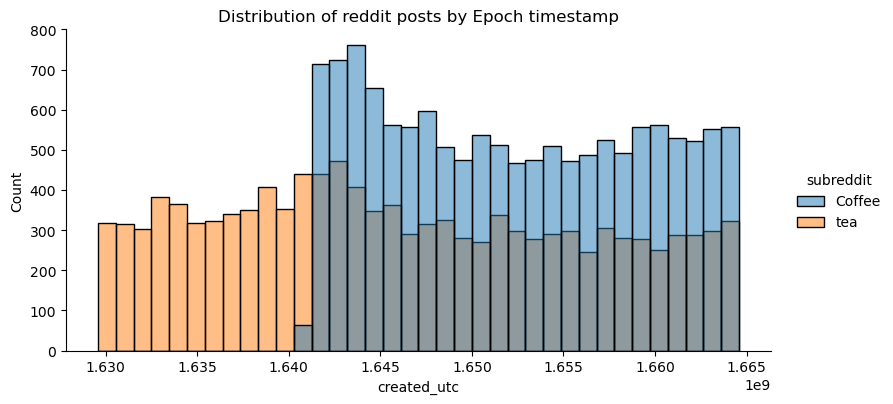

In [26]:
drinks = pd.concat([coffee_extract, tea_extract], ignore_index = True) # combine with coffee and tea datasets

sns.displot(data = drinks, x = 'created_utc', hue = 'subreddit', height = 4, aspect = 2)
plt.title('Distribution of reddit posts by Epoch timestamp');

The first 15000 submissions for coffee was collected over a shorter period than tea, and the daily count of coffee posts compared to tea is significantly higher. <br>
From [Coffee Subreddit](https://www.reddit.com/r/Coffee/) & [Tea Subreddit](https://www.reddit.com/r/tea/), we can tell that the number of members in Coffee subreddit is almost twice that of Tea subreddit. <br>
Hence, we conclude that Coffee subreddit is more active than Tea subreddit.<br>

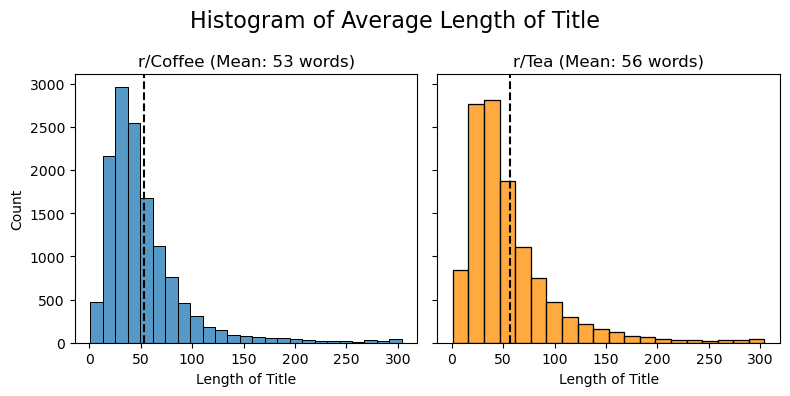

In [27]:
subplot_hist(coffee_extract, tea_extract, 'title', 'Histogram of Average Length of Title')

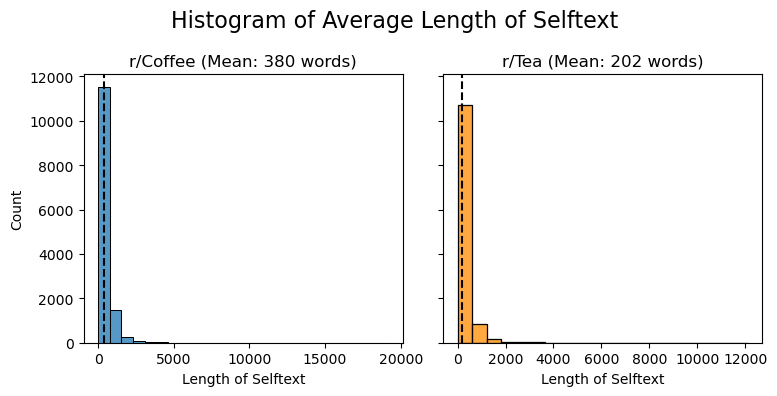

In [28]:
subplot_hist(coffee_extract, tea_extract, 'selftext', 'Histogram of Average Length of Selftext')

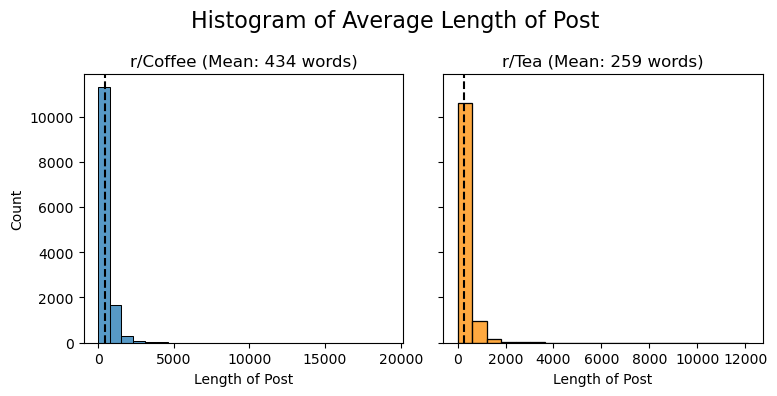

In [29]:
subplot_hist(coffee_extract, tea_extract, 'post', 'Histogram of Average Length of Post')

From the histograms above, 
- Both coffee and tea have a very similar mean number of words in their titles (53 vs 56)
- A bulk of coffee post have a length between 0 to 5000 words in selftext, while tea post have a length between 0 to 2000 words in selftext. This results in the average number of words per selftext in coffee being almost twice as much as that of tea. 
- Simiarly, after combining title and self text the mean length of post in coffee is slightly less than twice as much as that of tea.

## 2.2 Preprocessing

In [30]:
# drop title and selftext columns since post is a concatenation of both columns 
coffee_extract = coffee_extract[['created_utc', 'subreddit', 'post']]
tea_extract = tea_extract[['created_utc', 'subreddit', 'post']]

In [31]:
# apply demoji - translate emojis to text 
coffee_extract['post_demoji'] = coffee_extract['post'].apply(lambda x: demoji.replace_with_desc(x)) 
tea_extract['post_demoji'] = tea_extract['post'].apply(lambda x: demoji.replace_with_desc(x))

In [32]:
# add stop words to the existing list
stop_words = stopwords.words('english')
new_stop_words = ['like', 'just', 've', 'tried', 'thanks', 'advance', 'feel', 'good', 'make', 'use', 'know', 'don', 'time', 'amp', 
                'really', 'looking', 'using', 'want', 'does', 'new', 'https', 'www', 'webp', 'would', 'anyone', 'get', 'also', 
                'find', 'got', 'help', 'something', 'try', 'jpg', 'width', 'format', 'pjpg', 'auto', 'day', 'way', 'much', 'love', 'go', 'poll', 'reddit', 'com']


stop_words.extend(new_stop_words)

In this notebook, lemmitization is chosen over stemming so as to retain the context of the words. 

In [33]:
lemmatizer = WordNetLemmatizer() # instantiate Lemmatizer

def preprocessing(post): # function remove noise and clean text data
    post_remove_url = BeautifulSoup(post).get_text() # remove urls
    post_letters_only = re.sub('[^a-zA-Z]', ' ', post_remove_url) # special characters removal
    post_tokenize = post_letters_only.lower().split() # lowercase & tokenization
    
    stops = set(stop_words) # set stop words
    
    cleaned_words = [lemmatizer.lemmatize(i) for i in post_tokenize if i not in stops] # lemmatization
    return (' '.join(cleaned_words))

In [34]:
# add column to contain text after preprocessing
coffee_extract['post_processed'] = coffee_extract['post_demoji'].map(preprocessing)
tea_extract['post_processed'] = tea_extract['post_demoji'].map(preprocessing)

In [35]:
# function to obtain and plot top words for ngrams
def plot_topwords(df, col, n, ngram, subreddit):
    
    # CountVectorizer
    cvec = CountVectorizer(stop_words = stop_words, ngram_range = (n, n), min_df = 0.001)
    subreddit_cvec = pd.DataFrame(cvec.fit_transform(df[col]).toarray(), columns = cvec.get_feature_names())
    cvec_word_count = subreddit_cvec.sum().sort_values(ascending = False).head(30)
    
    # TfidfVectorizer
    tvec = TfidfVectorizer(stop_words = stop_words, ngram_range = (n, n), min_df = 0.001)
    subreddit_tvec = pd.DataFrame(tvec.fit_transform(df[col]).toarray(), columns = tvec.get_feature_names())
    tfidf_word_count = subreddit_tvec.sum().sort_values(ascending = False).head(30)
    
    fig, ax = plt.subplots(1, 2, figsize = (26,8))
    plt.suptitle(f'{ngram}: Top 30 words in {subreddit}', fontsize = 20)
    
    sns.barplot(x = cvec_word_count.values, y = cvec_word_count.index, ax = ax[0], palette = sns.color_palette('RdPu_r', 30))
    ax[0].set_title(f'CountVectorizer', size = 16)
    
    sns.barplot(x = tfidf_word_count.values, y = tfidf_word_count.index, ax = ax[1], palette = 'Blues_r')
    ax[1].set_title(f'TfidfVectorizer', size = 16)
    

## 2.3 EDA

### Coffee - Top words in Post

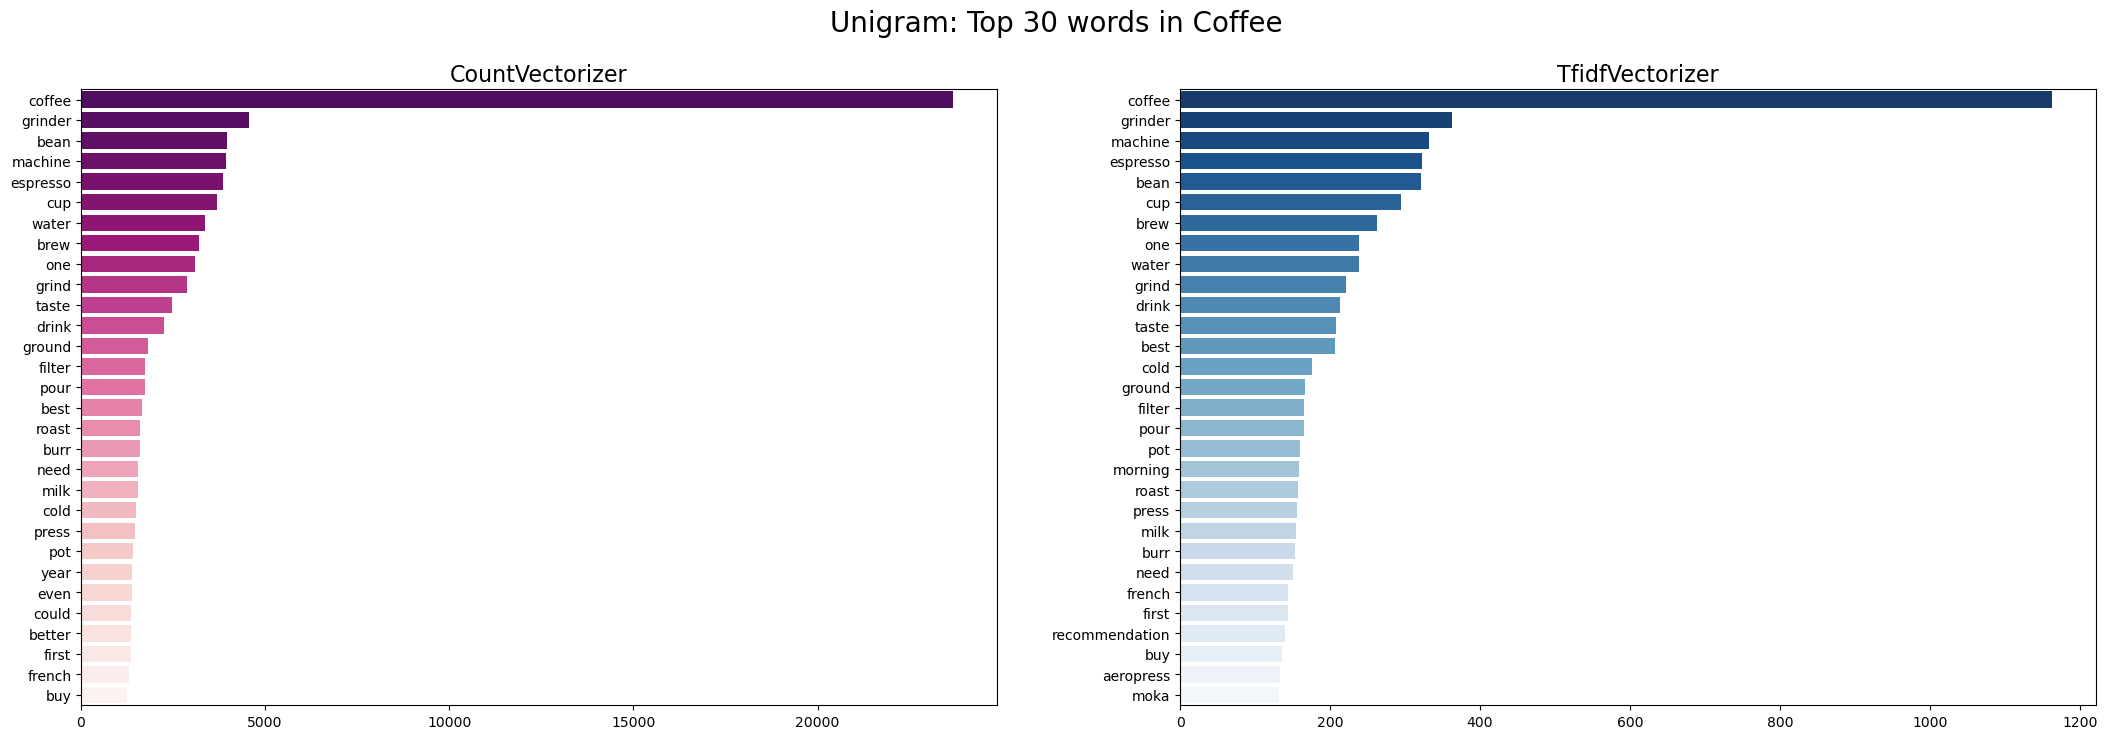

In [36]:
plot_topwords(coffee_extract, 'post_processed', 1, 'Unigram', 'Coffee')

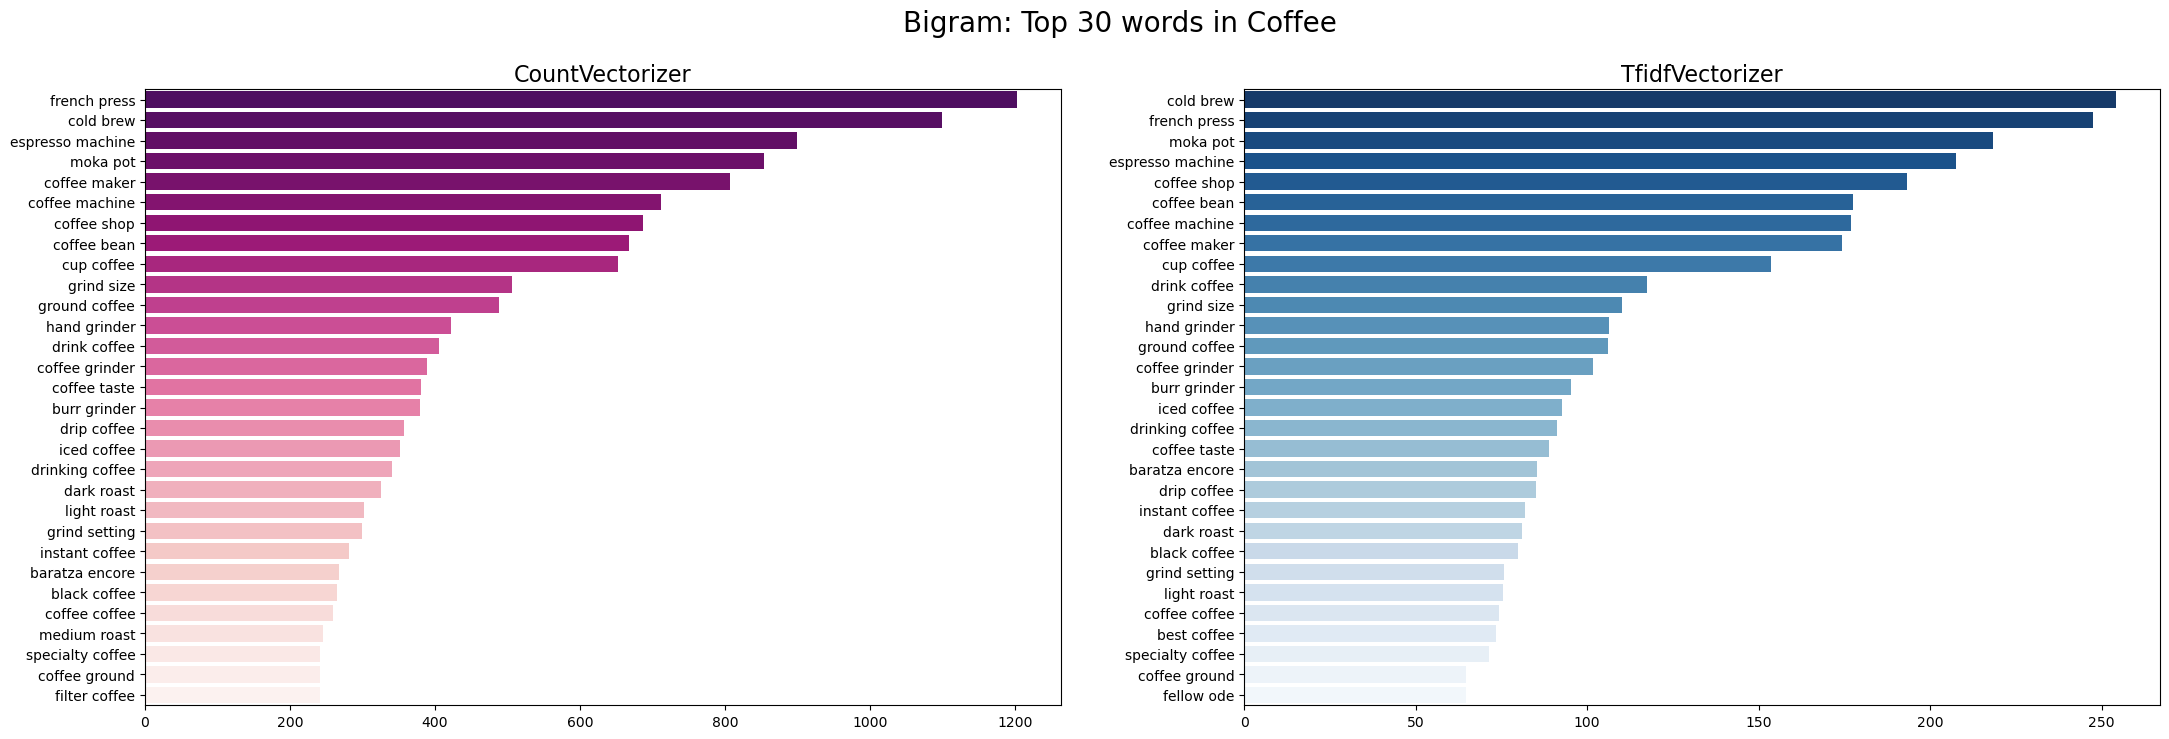

In [37]:
plot_topwords(coffee_extract, 'post_processed', 2, 'Bigram', 'Coffee')

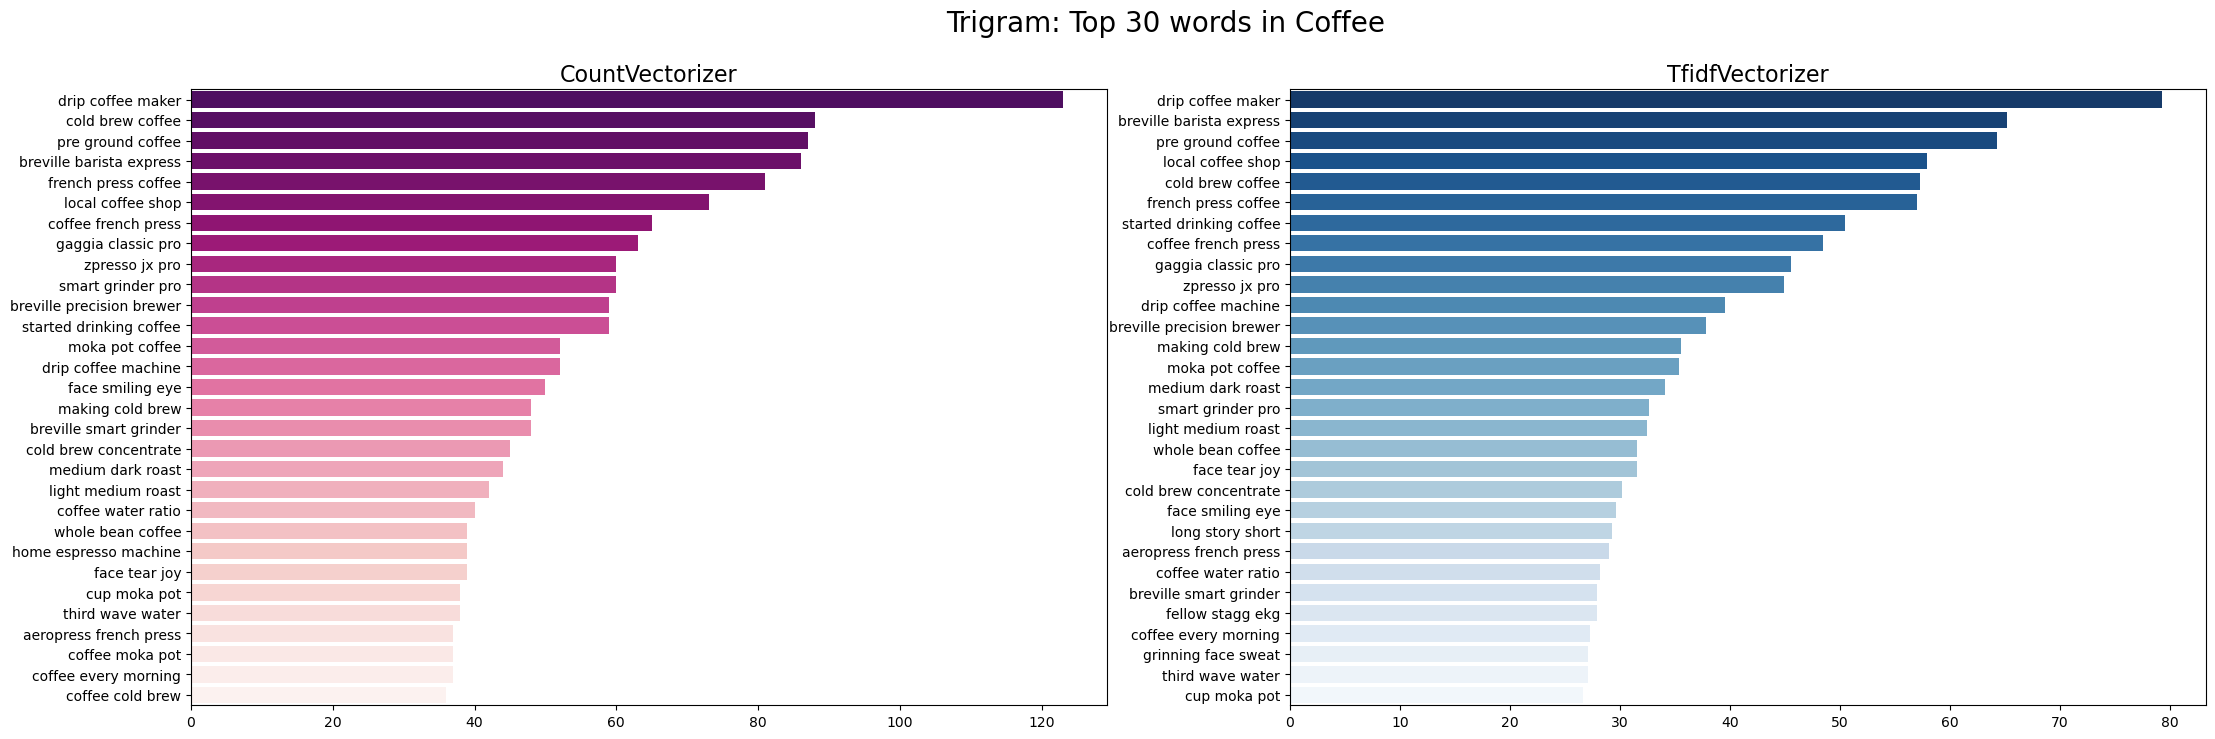

In [38]:
plot_topwords(coffee_extract, 'post_processed', 3, 'Trigram', 'Coffee')

### Tea - Top words in Post

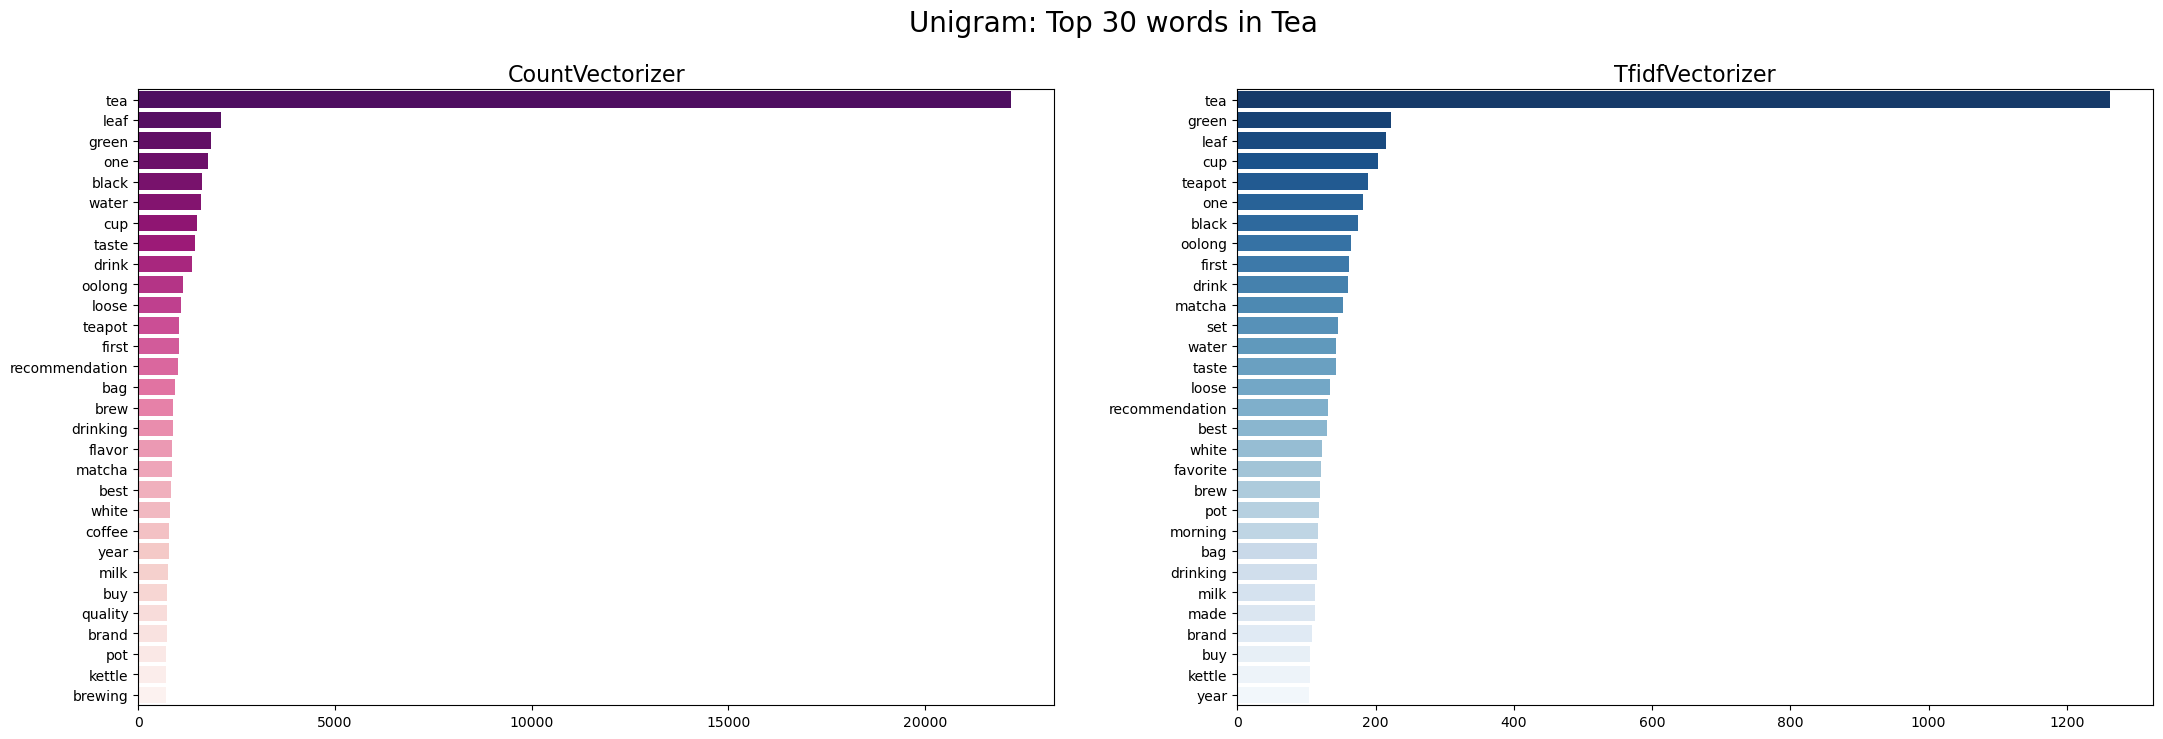

In [39]:
plot_topwords(tea_extract, 'post_processed', 1, 'Unigram', 'Tea')

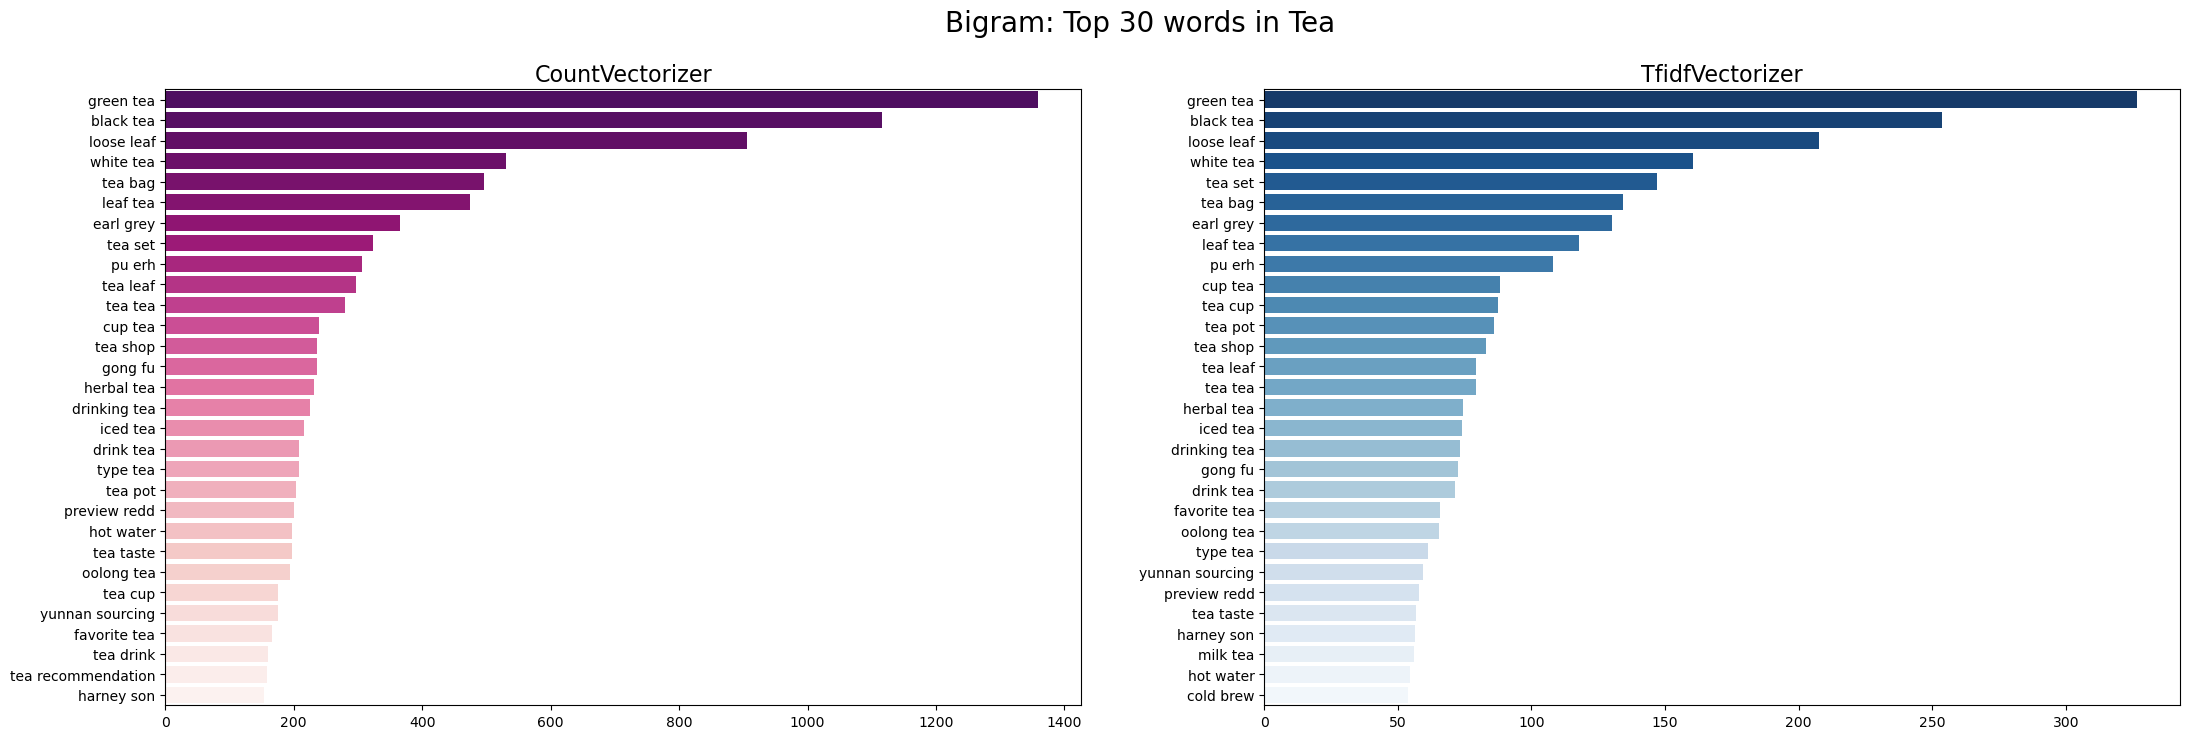

In [40]:
plot_topwords(tea_extract, 'post_processed', 2, 'Bigram', 'Tea')

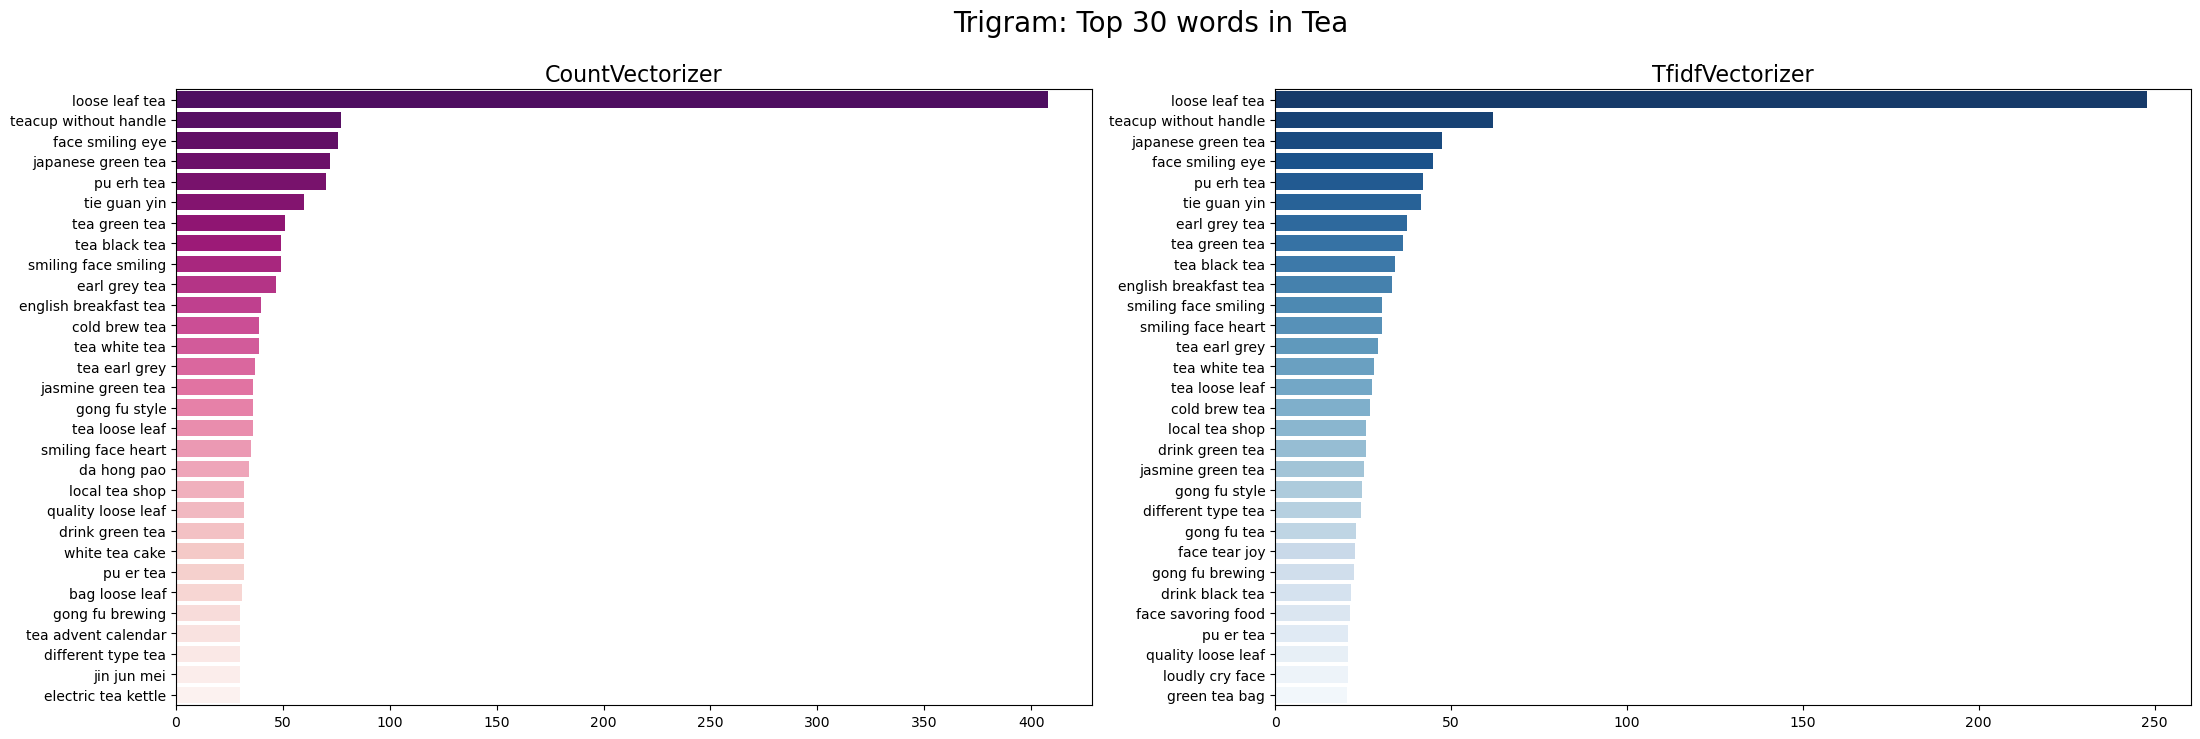

In [41]:
plot_topwords(tea_extract, 'post_processed', 3, 'Trigram', 'Tea')

#### Observations:
- Top words found in unigram plots seem to be too general and not helpful compared to the words in bigram and trigram plots
- The top words can be split into a few categories:
    - Types of coffee/tea
    - Types of coffee/tea brewing techniques
    - Types of equiments used for coffee/tea brewing
    - List of coffee/tea brands and equipment brands

## 2.4 Data Cleaning for Modeling

Coffee and tea related words were not added as part of preprocessing above, as they are important in identifying meaningful words in ngrams above. <br>
Now, these key words will be added as stop words and removed from the datasets to prevent overfitting during modeling in the next notebook.  

In [42]:
# extract only required columns for analysis
coffee_cleaned = coffee_extract[['subreddit', 'post_demoji']]
tea_cleaned = tea_extract[['subreddit', 'post_demoji']]

In [43]:
# add coffee/tea related stopwords
add_stop_words = ['coffee', 'coffe', 'coffees', 'tea','teas'] 
stop_words.extend(add_stop_words)

In [44]:
# combine coffee and tea datasets
drinks = pd.concat([coffee_cleaned, tea_cleaned])
drinks = drinks.reset_index(drop = True)

In [45]:
# encode coffee and tea
drinks['subreddit'] = drinks['subreddit'].map({'Coffee': 0, 'tea':1})

In [46]:
# preprocess demojized post again, with coffee/tea related stopwords
drinks['post_processed'] = drinks['post_demoji'].map(preprocessing)

In [47]:
drinks.drop(columns = ['post_demoji'], inplace = True) # column no longer needed after preprocessing

In [48]:
# export cleaned datasets
coffee_extract.to_csv('../datasets/coffee_extract.csv', index = False)
tea_extract.to_csv('../datasets/tea_extract.csv', index = False)
drinks.to_csv('../datasets/drinks.csv', index = False)